# Data Formats

In this tutorial, we will cover several manipulations of data formats:
- TIFF
- NetCDF4
- HDF5
- Zarr
- Pickle
- JSON
- CSV vs Parquet (practice again)

In [2]:
!pip install wget

  Using cached wget-3.2-py3-none-any.whl


In [3]:
import requests, zipfile , os, io
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
# import netCDF4 as nc
import numpy as np
import pandas as pd
import pycrs
import rasterio
import h5py
import rasterio
import netCDF4 as nc
import wget


from folium.plugins import MarkerCluster
from rasterio.mask import mask
from rasterio.plot import show
from urllib.request import urlopen

## Raster data: rasterio

Raster data is any pixelated (or gridded) data where each pixel is associated with a specific geographical location. The value of a pixel can be continuous (e.g. elevation) or categorical (e.g. land use).



https://rasterio.readthedocs.io/en/latest/

https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/

https://geohackweek.github.io/raster/

We will download topography files from there (data saved onto a Dropbox folder)

https://www.naturalearthdata.com/downloads/50m-raster-data/50m-cross-blend-hypso/



In [4]:
# Dowload the data using wget
wget.download("https://www.dropbox.com/s/r75ecms0bvyqaca/HYP_50M_SR.zip?dl=1")

'HYP_50M_SR.zip'

Unzip the file

In [5]:

# url='https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/HYP_50M_SR.zip'
# s = requests.get(url) 
#creating the directory
os.makedirs("./HYP_50M_SR/",exist_ok=True)
# wget.download(url,out="HYP_50M_SR") # this does not work on the hub
z = zipfile.ZipFile("HYP_50M_SR.zip")
z.extractall('./HYP_50M_SR/')

In [6]:
elevation = rasterio.open('HYP_50M_SR/HYP_50M_SR.tif')

In [7]:
elevation.shape

(5400, 10800)

In [9]:
print(elevation)

<open DatasetReader name='HYP_50M_SR/HYP_50M_SR.tif' mode='r'>


Let us have a look at the dimensions of the data:

In [9]:
elevation.height

5400

In [10]:
elevation.width

10800

In [ ]:
elevation.indexes

Can you guess on how to call the data types of the file entry?

In [11]:
# type below
elevation

<open DatasetReader name='HYP_50M_SR/HYP_50M_SR.tif' mode='r'>

and at the boundaries of the dataset:

In [ ]:
elevation.bounds

In [12]:
print(elevation.transform * (0, 0)) # North West corner
print(elevation.transform * (elevation.width, elevation.height)) # South East corner

(-179.99999999999997, 90.0)
(179.99999999996405, -89.99999999998201)


Here is the projection used for the data:

In [13]:
elevation.crs

CRS.from_epsg(4326)

How to interpret the data: There are three layers for the three colors red, green, and blue:

In [14]:
print(elevation.colorinterp[0])
print(elevation.colorinterp[1])
print(elevation.colorinterp[2])

ColorInterp.red
ColorInterp.green
ColorInterp.blue


In [15]:
print(np.min(elevation.read(1)), np.max(elevation.read(1)))
print(np.min(elevation.read(2)), np.max(elevation.read(2)))
print(np.min(elevation.read(3)), np.max(elevation.read(3)))

59 255
79 255
75 255


Let us now plot the data:

In [16]:
image = elevation.read()

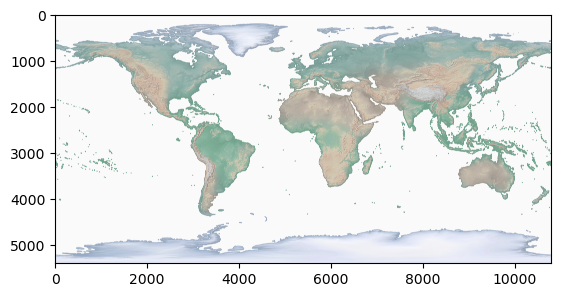

<AxesSubplot: >

In [18]:
show(image)

##  geojson

Shapefiles are not the only kind of files that we can read with geopandas. Let us look at an example of reading data from a geojson file (which is a special case of json file with geographical coordinates).

You can find more about json in:

https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/apis-in-python/

In [19]:
url = 'https://www.nps.gov/lib/npmap.js/4.0.0/examples/data/national-parks.geojson'

In [20]:
parks = gpd.read_file(url)

In [21]:
parks.head()

,Code,Name,geometry
0,FRLA,Frederick Law Olmsted National Historic Site,POINT (-71.13113 42.32551)
1,GLDE,Gloria Dei Church National Historic Site,POINT (-75.14358 39.93438)
2,JOFI,John F Kennedy National Historic Site,POINT (-71.12296 42.34660)
3,LONG,Longfellow House - Washington's Headquarters N...,POINT (-71.12590 42.37702)
4,ROWI,Roger Williams National Memorial,POINT (-71.41080 41.82835)


Let us plot the data.

folium is a nice Python package for visualization. You can learn more in the following notebook:

https://github.com/geohackweek/tutorial_contents/blob/master/visualization/notebooks/foliumTutorial.ipynb

In [22]:
m = folium.Map(location=[40, -100], zoom_start=4)
folium.GeoJson(parks).add_to(m)
marker_cluster = MarkerCluster().add_to(m)
m

We are going to focus on the parks in Washington State:

In [23]:
parks_WA = parks.iloc[[94, 127, 187, 228, 286, 294, 295, 297, 299, 300, 302]].reset_index()

We create a list of locations to add popups to the map.

In [24]:
locations = []
for index in range(0, len(parks_WA)):
    location = [parks_WA['geometry'][index].y, parks_WA['geometry'][index].x]
    locations.append(location)

In [25]:
m = folium.Map(location=[47, -121], zoom_start=7)
marker_cluster = MarkerCluster().add_to(m)
for point in range(0, len(locations)):
    folium.Marker(location = locations[point], popup=parks_WA['Name'].iloc[point]).add_to(marker_cluster)
m

## Hierarchical formats: NETCDF4 & HDF5

Hierarchical data formats are designed to store large amount of data into a single file. They mimic a file system (e.g., tree-like data structure with nested directories) into a single file.  There are two domiment hierarchical data formats (HDF5 and NETCDF4), and one emerging for cloud (Zarr). Hierarchical formats in general can store many data types (numeric vs string).

## HDF5
The Hierarchical Data Format version 5 (HDF5), is an open source file format that supports large, complex, heterogeneous data. HDF5 uses a "file directory" like structure that allows you to organize data within the file in many different structured ways, as you might do with files on your computer. The HDF5 format also allows for embedding of metadata making it _self-describing_.
HDF5 files are self describing - this means that all elements (the file itself, groups and datasets) can have associated metadata that describes the information contained within the element.


HDF Structure Example:
- Datasets, which are typed multidimensional arrays
- Groups, which are container structures that can hold datasets and other groups


<img src="hdf5_structure4.jpeg" alt="An illustration of a H5 data set " />
Figure: HDF5 data example. Found in [neonscience](https://www.neonscience.org/resources/learning-hub/tutorials/about-hdf5)

## Netcdf

The network Common Data Form, or **netCDF**, was created in the early 1990s, and set out to solve some of the challenges in working with N-dimensional arrays. Netcdf is a collection of self-describing, machine-independent binary data formats and software tools that facilitate the creation, access and sharing of scientific data stored in N-dimensional arrays, along with metadata describing the contents of each array. Netcdf was built by the climate science community at a time when regional climate models were beginning to produce larger and larger output files. NetCDF version 4 is now a subset of HDF5.


### Handling large arrays
The NetCDF & H5 format have no limit on file sizes. However, any analysis tools that read data from a NetCDF array into memory for some computational operation will be limited by that particular machine's available memory. 

### But slow at I/O
When reading a hierarchical file, the whole tree of the data structure is scanned from the root node down. Since it has to be done each time a user makes an inquiry, reading H5 and Netcdf is **slow**. There are faster



The data files for this part can be downloaded here:

https://www.sciencebase.gov/catalog/item/5cfeb4cce4b0156ea5645056

In [ ]:
file1 = 'NCM_GeologicFrameworkGrids.nc'
file2 = 'NCM_SpatialGrid.nc'
geology = nc.Dataset(file1)
grid = nc.Dataset(file2)

In [ ]:
geology

In [ ]:
geology['Surface Elevation']

In [ ]:
np.shape(geology['Surface Elevation'])

In [ ]:
geology['Surface Elevation'][3246, 1234]

In [ ]:
x = grid['x'][0:4901, 0:3201]
y = grid['y'][0:4901, 0:3201]
elevation = geology['Surface Elevation'][0:4901, 0:3201]

In [ ]:
plt.contourf(x, y, elevation)

## Zarr


Zarr is a cloud-optimized data format that handles heterogeneous data sets.

In the following exercise, we will use the Xarray open data sets air_temperature and save it into a Zarr file.

Let's work in groups to :
- Download the xarray data
- Save it in to file, report on time and size of the data set.
- Read it again and check again write time and read times

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#import pooch
import pooch
import zarr

%matplotlib inline
%config InlineBackend.figure_format='retina'
ds = xr.tutorial.load_dataset("air_temperature")

In [32]:
(ds)

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [ ]:
z1=zarr.open('.data/example_TP.zarr')

In [31]:
dszarr=ds.to_zarr('data./example_TP.zarr')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/dataset.py:2077: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore
